<a href="https://colab.research.google.com/github/victorbjorsvik/NOVA_Bridging_Python/blob/main/ADA_week3_lecture2_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Data Analysis - week 3, lecture 2

In the advanced data analysis course, we assume basic knowledge of Python, as could be acquired by attending the *Introduction to Programming* bridging course.

This notebook includes the examples and exercises presented in **Week 3**, lecture 2. There is an additional notebook with the examples and exercises suggested for autonomous study during the week.



In [5]:
# Install needed software
# Run this cell once before running the other cells in the notebook

!apt-get install openjdk-17-jdk-headless
!pip install pyspark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 18 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.8.1+1~us1-0ubuntu1~22.04 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.8.1+1~us1-0ubuntu1~22.04 [71.1 MB]
Fetched 119 MB in 4s (30.1 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Re

In [6]:
# Install needed data
# Run this cell once before running the other cells in the notebook

!pip install gdown
!gdown 'https://drive.google.com/uc?id=1Suzt37ohetSKLNP0kFUv0Ji1joiXumir'
!unzip -o sbe_data_2324.zip

Downloading...
From: https://drive.google.com/uc?id=1Suzt37ohetSKLNP0kFUv0Ji1joiXumir
To: /content/sbe_data_2324.zip
100% 1.07M/1.07M [00:00<00:00, 31.7MB/s]
Archive:  sbe_data_2324.zip
  inflating: data/AD-covid.csv       
  inflating: data/AE-covid.csv       
  inflating: data/AF-covid.csv       
  inflating: data/AG-covid.csv       
  inflating: data/AL-covid.csv       
  inflating: data/ALL-covid.csv      
  inflating: data/AM-covid.csv       
  inflating: data/AO-covid.csv       
  inflating: data/AR-covid.csv       
  inflating: data/AT-covid.csv       
  inflating: data/AU-covid.csv       
  inflating: data/AW-covid.csv       
  inflating: data/AZ-covid.csv       
  inflating: data/BA-covid.csv       
  inflating: data/BB-covid.csv       
  inflating: data/BD-covid.csv       
  inflating: data/BE-covid.csv       
  inflating: data/BF-covid.csv       
  inflating: data/BG-covid.csv       
  inflating: data/BH-covid.csv       
  inflating: data/BI-covid.csv       
  inflating: dat

## Programming (with Spark SQL)

We now show how to program in Python using [**Spark SQL**](https://spark.apache.org/docs/latest/index.html).

For using Spark, we need to import the necessary libraries. In the following cell we also print the version of pyspark.

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

print(pyspark.__version__)


3.5.0


In [8]:
#Let's import other libraries
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports standard Pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

# imports pandas API for Spark as ps
import pyspark.pandas as ps


For accessing the Spark system, we need to create a SparkSession.
The Spark session accessed is in the local machine - ```master("local")```.

The ```.config("spark.sql.execution.arrow.pyspark.enabled", "true")``` configuration specifies that the the arrow library can be used - this will allow to convert Spark DataFrames into Pandas DataFrames.


In [9]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Simple test") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()


### Data model : Table

In *Spark SQL*, a table is created from a Spark [**DataFrame**](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes). (follow the link for DataFrame documentation)

#### Creating Spark DataFrames (1)

From a Pandas Dataframe, you can use ```sparkDF = spark.createDataFrame(pandasDF)``` to create a Spark Dataframe.

In [10]:
population = pd.DataFrame( { "country": ["PT", "ES", "DE"] , \
                            "population": [10276617, 46937060, 83019213]})

populationSDF = spark.createDataFrame(population)

populationSDF.printSchema()

root
 |-- country: string (nullable = true)
 |-- population: long (nullable = true)



Spark DataFrames cannot be directly printed - note that a Spark DataFrame is distributed over multiple machine. For displaying the data, it is possible to use dataframe.show().


In [11]:
populationSDF.show()

+-------+----------+
|country|population|
+-------+----------+
|     PT|  10276617|
|     ES|  46937060|
|     DE|  83019213|
+-------+----------+



#### Creating Spark DataFrames (2)

It is possible to create a Spark DataFrame from a Python dictionary, as follows:

The equivalent Pandas code is the following:
```
population = pd.DataFrame( { "country": ["PT", "ES", "DE"] , \
                            "population": [10276617, 46937060, 83019213]})

print( population)
```

In [12]:
populationSDF2 = spark.createDataFrame( [("PT",10276617), ("ES",46937060), ("DE",83019213)], \
                                    ["country","population"])

populationSDF2.show()


+-------+----------+
|country|population|
+-------+----------+
|     PT|  10276617|
|     ES|  46937060|
|     DE|  83019213|
+-------+----------+



#### Using Spark DataFrames in Python

If you want to use the data in a Spark DataFrame with some code written in Python, it is necessary to collect the data (that will be in multiple machines) before using it.

This can be done by using the **dataframe.collect()** function, which returns a list of Rows.


In [13]:
populationData = populationSDF.collect() # Collect the DataFrame into a list
print(populationData[:5])               # Print the first 5 rows

[Row(country='PT', population=10276617), Row(country='ES', population=46937060), Row(country='DE', population=83019213)]


Alternatively, it is possible to collect the information to a Pandas DataFrame as follows:

In [14]:
populationDF = populationSDF.toPandas() # Collect the DataFrame into a Pandas DataFrame
print(populationDF.head(5))

  country  population
0      PT    10276617
1      ES    46937060
2      DE    83019213


#### Loading DataFrame from CSV files (1)

More often, will want to load the data from files. To create a DataFrame from a CSV file, you can use the Pandas Spark API.

We will also rename the column **Educational level** into **EducationalLevel**, as spaces in the names of columns makes some operations impossible in Spark SQL.

In [15]:
# Let's create a PATH in a OS independent way
# File lec1-example.csv is in directory data
fileName = os.path.join( "data", "lec1-example.csv")

# Read a CSV file into a DataFrame
dfPS = ps.read_csv(fileName)

# Convert Pandas Spark DataFrame into Spark DataFrame
dfS = dfPS.to_spark()
dfS = dfS.withColumnRenamed("Educational level", "EducationalLevel")
dfS.printSchema()


root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EducationalLevel: double (nullable = true)
 |-- Company: string (nullable = true)



/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


#### Loading DataFrame from CSV files (2)

An alternative to load a CSV file is to use the Spark native load function ```spark.read.option(...).csv(filename)```.

When reading a CSV file, use option **header** to specify whether the file has an header line or not, and **inferSchema** to specify whether Spark should try to infer the types of columns: string, integer, etc.


In [16]:
# Let's create a PATH in a OS independent way
# File lec1-example.csv is in directory data
fileName = os.path.join( "data", "lec1-example.csv")

# Read a CSV file into a DataFrame
dfS2 = spark.read.option("header", True).option("inferSchema",True).csv(fileName)
dfS2 = dfS2.withColumnRenamed("Educational level", "EducationalLevel")

dfS2.printSchema()


root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EducationalLevel: double (nullable = true)
 |-- Company: string (nullable = true)



### From DataFrames to SQL table and back

In Spqrk SQL, it is possible to register a DataFrame as a SQL temporaary view, using the function ```dataframe.createOrReplaceTempView(name)```.

After this, it is possible to execute SQL operations using (mostly) the standard SQL syntax.

The following operation registers the Dataframe with data from ```dfS``` under the name **persons** (and ```dfS2``` under **persons2**).

In [17]:
dfS.createOrReplaceTempView("persons")
dfS2.createOrReplaceTempView("persons2")

### Data processing with Spark SQL

We now show the transformations necessary to perform the exercises proposed above.


#### SELECT statement

For executing SQL statements, Spark SQL provides the operation ```spark.sql( stmt)```. The result of this operation is a DataFrame.

The key SQL statement is ```SELECT cols FROM table``` that allows to access data in a SQL table.  
The following code select all rows (```*```) from table *persons*.

In [18]:
result = spark.sql( "SELECT * FROM persons")
result.show(5)


+--------+---+----------------+-------+
|    Name|Age|EducationalLevel|Company|
+--------+---+----------------+-------+
|  Andrew| 55|             1.0|   Good|
|Bernhard| 43|             2.0|   Good|
|Carolina| 37|             5.0|    Bad|
|  Dennis| 82|             3.0|   Good|
|     Eve| 23|             3.2|    Bad|
+--------+---+----------------+-------+
only showing top 5 rows



We now list **persons2** tables just to check that the alternative functions for creating a table work the same way.

In [19]:
result = spark.sql( "SELECT * FROM persons2")
result.show(5)



+--------+---+----------------+-------+
|    Name|Age|EducationalLevel|Company|
+--------+---+----------------+-------+
|  Andrew| 55|             1.0|   Good|
|Bernhard| 43|             2.0|   Good|
|Carolina| 37|             5.0|    Bad|
|  Dennis| 82|             3.0|   Good|
|     Eve| 23|             3.2|    Bad|
+--------+---+----------------+-------+
only showing top 5 rows



And now we select only columns *name* and *age*.

The equivalent Spark Pandas API code is the following:

```
# Select the persons that are good company.
persons_age = dfPS[["Name","Age"]]

print(persons_age)
```

In [20]:
# Select the Name and Age.
result = spark.sql("SELECT name, age FROM persons")

result.show(5)

+--------+---+
|    name|age|
+--------+---+
|  Andrew| 55|
|Bernhard| 43|
|Carolina| 37|
|  Dennis| 82|
|     Eve| 23|
+--------+---+
only showing top 5 rows



#### Selecting rows based on conditions

It is possible to select only the rows for which a column has a given value by using ```SELECT cols FROM table WHERE condition``` - in the condition, columns are expressed by their names.

The equivalent Spark Pandas API code is the following:

```
# Select the persons that are good company.
goodPS = dfPS[dfPS["Company"] == "Good"]
```

**NOTE:** SQL is not case sensitive - you can use upper or lower case for SQL keywords, table and column names, etc. It is a common practice to use SQL keywords in upper-case and table and column name in lowwer case.


In [21]:
# Select the persons that are good company.
good = spark.sql("SELECT * FROM persons WHERE company = 'Good'")

good.show()


+--------+---+----------------+-------+
|    Name|Age|EducationalLevel|Company|
+--------+---+----------------+-------+
|  Andrew| 55|             1.0|   Good|
|Bernhard| 43|             2.0|   Good|
|  Dennis| 82|             3.0|   Good|
|    Fred| 46|             5.0|   Good|
|   James| 42|             4.1|   Good|
|     Lea| 38|             2.5|   Good|
|   Nigel| 71|             2.3|   Good|
+--------+---+----------------+-------+



The next code uses a more complex condition.

**Note:** In Pyhton, it is possible to create a multi-line string using the syntax
```
""" line 1
...
line n"""
```

In [22]:
# Select the persons that are good company and have educational level larger than 3.
goodEd3plus = spark.sql("""SELECT * FROM persons
                                    WHERE company = 'Good' AND EducationalLevel >= 3.0
                        """)
goodEd3plus.show()

+------+---+----------------+-------+
|  Name|Age|EducationalLevel|Company|
+------+---+----------------+-------+
|Dennis| 82|             3.0|   Good|
|  Fred| 46|             5.0|   Good|
| James| 42|             4.1|   Good|
+------+---+----------------+-------+



In [28]:
# Exercise from lecture
# Compute the number of persons that are good and bad company for persons that are older than the average age of persons.

ans = spark.sql("""SELECT  company, COUNT(*) AS over_avg FROM persons
                                  WHERE age > (SELECT AVG(age) FROM persons)
                                  GROUP BY company
                """)
ans.show()

+-------+--------+
|company|over_avg|
+-------+--------+
|   Good|       4|
|    Bad|       1|
+-------+--------+



#### Creating new views in SQL

In Spark SQL, besides using ```dataframe.createOrReplaceTempView(name)``` to register a new view, it is possible to register a new view in SQL, using the following statement ```CREATE OR REPLACE TEMPORARY VIEW name AS SELECT ....```.

The following code register a view with name *good* by selecting the persons that are good companies.

NOTE: A view is a table that is the result of a query.


In [29]:
spark.sql("""CREATE OR REPLACE TEMPORARY VIEW good AS
                SELECT * FROM persons WHERE company = 'Good'""")

DataFrame[]

Let's check that we can access to good table/view.

In [30]:
goodAlt = spark.sql("SELECT * FROM good")
goodAlt.show()

+--------+---+----------------+-------+
|    Name|Age|EducationalLevel|Company|
+--------+---+----------------+-------+
|  Andrew| 55|             1.0|   Good|
|Bernhard| 43|             2.0|   Good|
|  Dennis| 82|             3.0|   Good|
|    Fred| 46|             5.0|   Good|
|   James| 42|             4.1|   Good|
|     Lea| 38|             2.5|   Good|
|   Nigel| 71|             2.3|   Good|
+--------+---+----------------+-------+



#### Deleting view

For deleting/unregistering a view from Spark SQL, you can use the ```DROP VIEW name```statement. After this, acessing the table will lead to an **error**!

In [31]:
# Let's register the previous dataframe as goodalt
goodAlt.createOrReplaceTempView("goodalt")
# and select all rows to check that it exists
goodAlt = spark.sql("SELECT * FROM goodalt")
goodAlt.show()

# Now, we unregister the view
spark.sql("DROP VIEW goodalt")
# and check that we get an error when accessing the view
goodAlt = spark.sql("SELECT * FROM goodalt")
goodAlt.show()



+--------+---+----------------+-------+
|    Name|Age|EducationalLevel|Company|
+--------+---+----------------+-------+
|  Andrew| 55|             1.0|   Good|
|Bernhard| 43|             2.0|   Good|
|  Dennis| 82|             3.0|   Good|
|    Fred| 46|             5.0|   Good|
|   James| 42|             4.1|   Good|
|     Lea| 38|             2.5|   Good|
|   Nigel| 71|             2.3|   Good|
+--------+---+----------------+-------+



AnalysisException: ignored

#### Applying reduce/aggregation functions

Spark SQL allows to compute a function for the values of one or multiple columns using the following syntax ```SELECT fun1(col1),... FROM ...```, where fun1 is an existing Spark function.

The following example computes first, the minimum age (```min```function), and then the minimum of both *Age* and *Educational level* at the same time. Spark has multiple useful aggregation functions, including, maximum (```max```), minimum (```min```), mean (```mean```), median (```percentile_approx(col,0.5)```), standard deviation (```std```), etc. - check the  [Spark SQL **built-in** functions documentation](https://spark.apache.org/docs/latest/api/sql/index.html) for the list of available functions.

The equivalent Spark Pandas SQL code is the follopwing:

```
minAgePS = goodPS["Age"].min()
print( "Minimum age is ")
print( minAgePS)


minsPS = goodPS.agg({"Age":"min","Educational level":"min"})
print( "Minimum information for several columns now")
print(minsPS)
```

In [33]:
minAge = spark.sql("SELECT MIN(age) FROM good")
print( "Minimum age is ")
print( minAge.collect()[0][0])


mins = spark.sql("SELECT MIN(age), MIN(EducationalLevel) FROM good")
print( "Minimum information for several columns now")
mins.show()


Minimum age is 
38
Minimum information for several columns now
+--------+---------------------+
|min(age)|min(EducationalLevel)|
+--------+---------------------+
|      38|                  1.0|
+--------+---------------------+



It is possible to execute different function to different columns.
It is also possible to make rename the columns using the keyword ```AS``` for the following syntax: ```SELECT fun(...) AS name, ... FROM ....```.

The equivalent Pandas / Spark Pandas code without rename (and returning the result in rows) is the following:
```
goodPS.agg( {"Age":["min","max"],"Educational level":"median"})
```


In [34]:
minAge = spark.sql("""SELECT MIN(age) AS min,
                             MAX(age) AS max,
                             PERCENTILE(EducationalLevel,0.5) AS median
                            FROM good""")
minAge.show()

+---+---+------+
|min|max|median|
+---+---+------+
| 38| 82|   2.5|
+---+---+------+



Wait, this was not what we wanted in the first place - we want the information about the youngest person that is a good company.

There is no function to return the N smallest (or largest elements) in Spark SQL, but it is possible to: (1) order the elements by the value of some columns ```SELECT .... FROM .... ORDER BY col1,...``` or ```SELECT .... FROM .... ORDER BY col1 DESC,...``` for ordering in descending order; and (2) use limit to specify the number of rows returned ```SELECT .... FROM .... LIMIT num```.

The equivalent code in Spark Pandas API is the following:

```
youngestGoodPS = goodPS.sort_values(by="Age")
print(youngestGoodPS[:1])
```

In [35]:
youngestGood = spark.sql("""SELECT *
                            FROM good
                            ORDER BY age
                            LIMIT 1
                            """)
youngestGood.show()


+----+---+----------------+-------+
|Name|Age|EducationalLevel|Company|
+----+---+----------------+-------+
| Lea| 38|             2.5|   Good|
+----+---+----------------+-------+



We have discussed that if we only want the topmost value, in Pandas, using ```goodPS.nsmallest(1,["Age"])``` is more efficient than sorting.

In SQL there is no operation simillar to ```nlargest/nsmallest```.
Does it mean that we need to rely on the inneficient sort operation?

Let's use ```explain``` to tey to find out. First, we asked Spark to explain the steps to execute the SQL code.


In [ ]:
youngestGood.explain()


== Physical Plan ==
TakeOrderedAndProject(limit=1, orderBy=[age#48 ASC NULLS FIRST], output=[Name#47,Age#48,EducationalLevel#386,Company#50])
+- *(1) Project [Name#47, Age#48, Educational level#49 AS EducationalLevel#386, Company#50]
   +- *(1) Filter (isnotnull(company#50) AND (company#50 = Good))
      +- FileScan csv [Name#47,Age#48,Educational level#49,Company#50] Batched: false, DataFilters: [isnotnull(Company#50), (Company#50 = Good)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/data/lec1-example.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Company), EqualTo(Company,Good)], ReadSchema: struct<Name:string,Age:int,Educational level:double,Company:string>




And now, we write the Pandas code that, from the original DataFrame, uses ```nsmallest``` to compute the bottom-most element.


In [ ]:
goodPS = dfPS[dfPS["Company"] == "Good"]
youngestGoodPS = goodPS.nsmallest(1,["Age"])
youngestGoodPS.to_spark().explain()


== Physical Plan ==
TakeOrderedAndProject(limit=1, orderBy=[Age#48 ASC NULLS LAST,__natural_order__#428L ASC NULLS FIRST], output=[Name#47,Age#48,Educational level#49,Company#50])
+- *(1) Project [Name#47, Age#48, Educational level#49, Company#50, monotonically_increasing_id() AS __natural_order__#428L]
   +- *(1) Filter CASE WHEN CASE WHEN isnull((Company#50 = Good)) THEN false ELSE isnull((Company#50 = Good)) END THEN false ELSE CASE WHEN isnull((Company#50 = Good)) THEN false ELSE (Company#50 = Good) END END
      +- FileScan csv [Name#47,Age#48,Educational level#49,Company#50] Batched: false, DataFilters: [CASE WHEN CASE WHEN isnull((Company#50 = Good)) THEN false ELSE isnull((Company#50 = Good)) END ..., Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/data/lec1-example.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Name:string,Age:int,Educational level:double,Company:string>




The execution plan is similar - this means that Spark, when executing a SQL statement, is optimizing the execution - it does not sort all data before getting the selected elements.

#### Applying reduce/aggregation functions per group

```SELECT fun1(col1), ... FROM ... GROUP BY colg1, ...``` allows to group the elements of a table/view before applying aggregation functions to the columns of the groups.

The following example computes the lowest age for each value of Company.

The equivalent Spark Dataframes code is the following:

```
youngest = df.select("Age","Company").groupby("Company").agg({"Age":"min"})
youngest.show()
```

In [36]:
youngest = spark.sql("""SELECT company, MIN(age) AS age
                            FROM persons
                            GROUP BY company
                            """)
youngest.show()


+-------+---+
|company|age|
+-------+---+
|   Good| 38|
|    Bad| 23|
+-------+---+



In Spark SQL there is no simple way to return the largest/smallest row of a group. It is possible to use Window function or ```JOIN```. We will get back to this when introducing Windows.


### Exercises

What transformations would you use to:

* Compute the average age of good and bad companies ?

* Know which group has lower average Education level: good or bad companies ?

In [40]:
# Compute the average age of good and bad companies

aver = spark.sql("""SELECT company, ROUND(AVG(age),2) as avg_age FROM persons
                    GROUP BY company""")
aver.show()


+-------+-------+
|company|avg_age|
+-------+-------+
|   Good|  53.86|
|    Bad|  34.71|
+-------+-------+



In [46]:
# Know which group has lower average Education level: good or bad companies ?

ed_level = spark.sql("""SELECT company, AVG(educationallevel) as avg_ed_level
                        FROM persons
                        GROUP BY company
                        ORDER by AVG(educationallevel)
                        """)

ed_level.show()


+-------+-----------------+
|company|     avg_ed_level|
+-------+-----------------+
|   Good|2.842857142857143|
|    Bad|4.314285714285714|
+-------+-----------------+



### Using SELECT results in SELECT statements

It is possble to use the result of a SELECT statement as part of another SELECT statement.

The following code counts the number of persons older than Fred.


In [47]:
result = spark.sql( """SELECT count(*) AS cnt FROM persons
                    WHERE age > (SELECT age FROM persons WHERE name = 'Fred')""")
result.show()

+---+
|cnt|
+---+
|  4|
+---+



### Exercise

Compute the number of persons that are good and bad company for persons that are older than the average age of persons.

In [50]:
#TODO: complete

spark.sql("""SELECT company, COUNT(*)
              FROM persons
              WHERE age > (SELECT AVG(age) from persons)
              GROUP BY company""").show()

+-------+--------+
|company|count(1)|
+-------+--------+
|   Good|       4|
|    Bad|       1|
+-------+--------+



### Plotting data with Spark SQL

For plotting, it is necessary to collect the data to print. We can get the data as the result of a SQL statement and use everything we studied before.


In [51]:
pdDF = spark.sql("SELECT * FROM persons").toPandas()


Executing the function ```plot()``` to a DataFrame just plots numeric values, with the X axis being the index.

<Axes: >

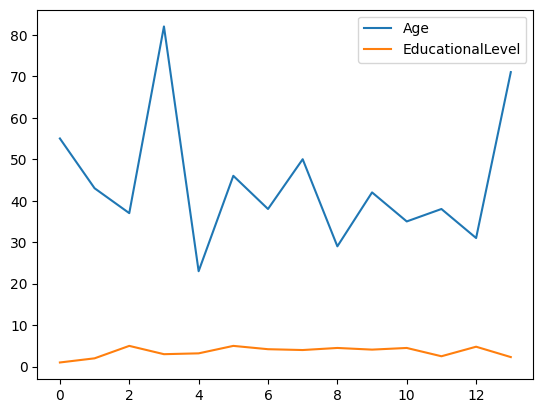

In [52]:
pdDF.plot()


You can specify which columns should be used for the X and Y axis, by passing values for ```x```and ```y``` parameters.

<Axes: xlabel='Name'>

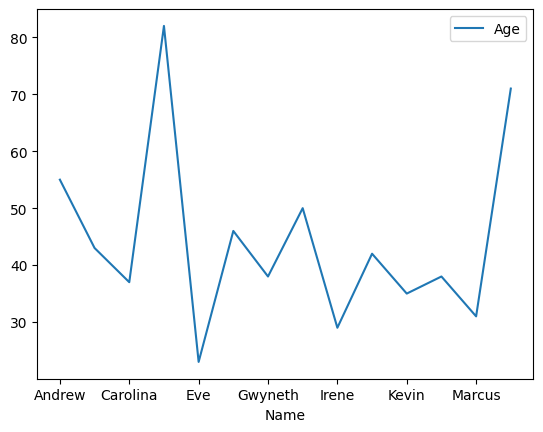

In [53]:
pdDF.plot(x="Name",y="Age")

The following example shows how to plot a histogram for companies, by computing the histogram values.


<Axes: xlabel='Company'>

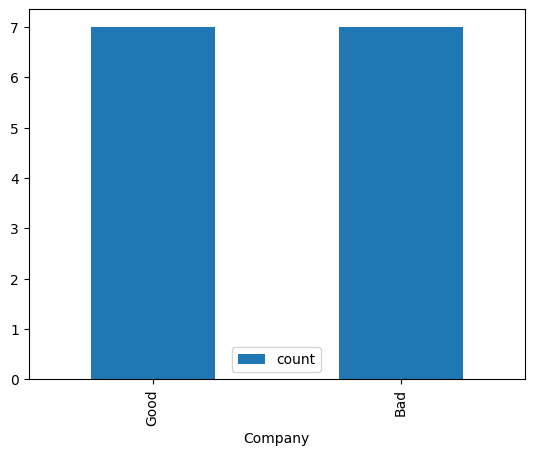

In [54]:
histDF = spark.sql("SELECT Company, count(*) AS count FROM persons GROUP BY company").toPandas()
histDF.plot(kind="bar",x="Company")

## Time-series

A time-series is a series of values that have a timestamp.

A time-series can be **Univariate** if it has a single feature (e.g. stock index, mortality, birth rate, etc.) , or **Multivariate** if it has multiple features (e.g. Weather, composed by (temperature, pressure, humidity, etc.)).



#### Example

In the examples, we will use data from COVID cases. The data files are in *data* directory, and consist of tables with 5 columns, *date*, *countrycode*, *population*, *cases*, *deaths*.

The name of the data files starts with the Internet code for the country, and has the format *CODE-covid.csv*, where CODE is the country code in uppercase.  

![table](images/table.png)

Let's read the data for Portugal.
<!--Unlike previous examples, we will use the date as the index, by passing ```index_col``` parameter in ```read_csv```function.-->

In [55]:
ptCovidFileName = os.path.join( "data", "PT-covid.csv")

# Read a CSV file into a DataFrame
ptCovidDF = spark.read.option("header", True).option("inferSchema",True).csv(ptCovidFileName)

# Converts the date into the datetime type
ptCovidDF = ptCovidDF.withColumn("date",to_date(col("date"), "yyyy-MM-dd"))

## Register Dataframe as a temporary view
ptCovidDF.createOrReplaceTempView("covidPT")

# Print the first 5 lines of data
ptCovidDF.show(5)


+----------+-----------+----------+-----+------+
|      date|countrycode|population|cases|deaths|
+----------+-----------+----------+-----+------+
|2020-03-02|         PT|  10276617|    0|     0|
|2020-03-03|         PT|  10276617|    0|     0|
|2020-03-04|         PT|  10276617|    3|     0|
|2020-03-05|         PT|  10276617|    3|     0|
|2020-03-06|         PT|  10276617|    5|     0|
+----------+-----------+----------+-----+------+
only showing top 5 rows



### Adding columns

Until now, the only one-to-* transformations we have seen consisted in filters and selecting a subset of columns. Sometime, it is interesting to add columns based on the values of the row.

In the previous example, we want to add columns with the number of cases and deaths per million inhabitants. We can use ```SELECT ... FROM ... ``` to return a DataFrame with as many columns as we want.

The equivalente Spark Pandas API code is the following:
```
ptCovidDF["casesPer1M"] = ptCovidDF["cases"] / ptCovidDF["population"] / 1000000
ptCovidDF["deathsPer1M"] = ptCovidDF["deaths"] / ptCovidDF["population"] / 1000000
```


In [56]:
ptCovidDF = spark.sql( """SELECT *, cases / population / 1000000 AS casesPer1M,
                                    deaths / population / 1000000 AS deathsPer1M
                                FROM covidPT
                        """)
# Print the first 5 lines of data
ptCovidDF.show(5)

+----------+-----------+----------+-----+------+--------------------+-----------+
|      date|countrycode|population|cases|deaths|          casesPer1M|deathsPer1M|
+----------+-----------+----------+-----+------+--------------------+-----------+
|2020-03-02|         PT|  10276617|    0|     0|                 0.0|        0.0|
|2020-03-03|         PT|  10276617|    0|     0|                 0.0|        0.0|
|2020-03-04|         PT|  10276617|    3|     0|2.919248620436083...|        0.0|
|2020-03-05|         PT|  10276617|    3|     0|2.919248620436083...|        0.0|
|2020-03-06|         PT|  10276617|    5|     0|4.865414367393472...|        0.0|
+----------+-----------+----------+-----+------+--------------------+-----------+
only showing top 5 rows



It is also possible to register the results as a new table/view.

In [57]:
spark.sql( """SELECT *, cases / population / 1000000 AS casesPer1M,
                                    deaths / population / 1000000 AS deathsPer1M
                                FROM covidPT
                        """).createOrReplaceTempView("covidPT2")

ptCovidDF = spark.sql("SELECT * FROM covidPT2")
# Print the first 5 lines of data
ptCovidDF.show(5)

+----------+-----------+----------+-----+------+--------------------+-----------+
|      date|countrycode|population|cases|deaths|          casesPer1M|deathsPer1M|
+----------+-----------+----------+-----+------+--------------------+-----------+
|2020-03-02|         PT|  10276617|    0|     0|                 0.0|        0.0|
|2020-03-03|         PT|  10276617|    0|     0|                 0.0|        0.0|
|2020-03-04|         PT|  10276617|    3|     0|2.919248620436083...|        0.0|
|2020-03-05|         PT|  10276617|    3|     0|2.919248620436083...|        0.0|
|2020-03-06|         PT|  10276617|    5|     0|4.865414367393472...|        0.0|
+----------+-----------+----------+-----+------+--------------------+-----------+
only showing top 5 rows



Let's plot the data, using two Y axis, specifying the columns to be used for the X and Y axis. ```secondary_y```allows to use a secondary index for the second line.

<Axes: xlabel='date'>

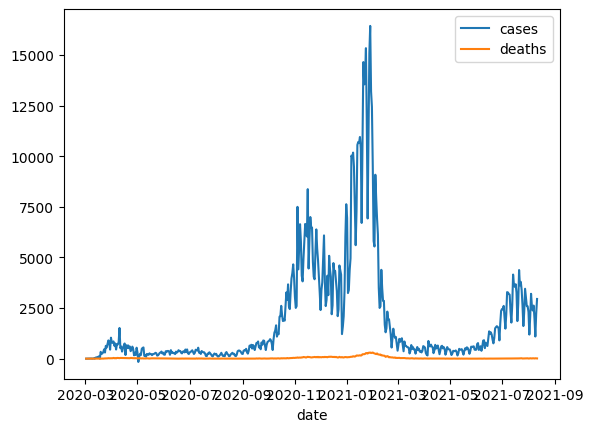

In [58]:
ptCovidPdDF = ptCovidDF.toPandas()

ptCovidPdDF.plot(x="date",y=["cases","deaths"])


<Axes: xlabel='date'>

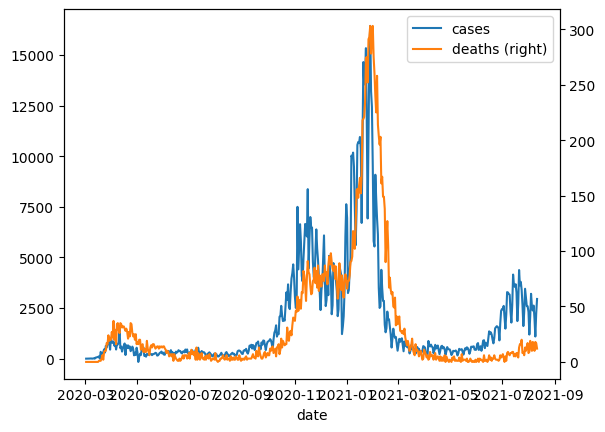

In [59]:
ptCovidPdDF.plot(x="date",y=["cases","deaths"],secondary_y=["deaths"])

It is also possible to use subplot to plot multiple lines, one at a time.

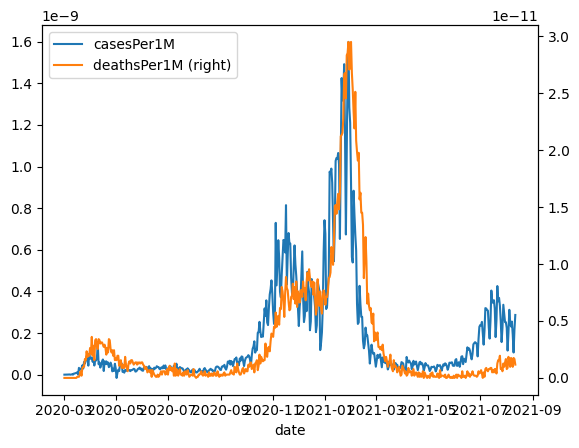

In [60]:
fig, axis = plt.subplots()
ptCovidPdDF.plot(ax=axis,x="date",y="casesPer1M")
ptCovidPdDF.plot(ax=axis,x="date",y="deathsPer1M",secondary_y="deathsPer1M")

plt.show()


## Exercises

### Compute the number of days for which the number of cases is larger than the average number of cases



In [62]:
spark.sql("""SELECT COUNT(date) as days_over_avg
              FROM covidpt
              WHERE cases > (SELECT AVG(cases) from covidpt)
              """).show()




+-------------+
|days_over_avg|
+-------------+
|          159|
+-------------+

